<a href="https://colab.research.google.com/github/pranay8297/esm/blob/main/notebooks/prot_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install transformers evaluate datasets requests pandas sklearn
! pip install datasets
! pip install evaluate

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached datasets-3.0.1-py3-none-any.whl.metadata (20 kB)
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 

In [1]:
import torch
from huggingface_hub import notebook_login

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# notebook_login()

In [4]:
print('token')

token


# Playground - 1

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
model_checkpoint = "facebook/esm2_t30_150M_UR50D"

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model_checkpoint = "facebook/esm2_t36_3B_UR50D"
train_labels = 100; test_labels = 20
num_labels = 120  # Add 1 since 0 can be a label
hf_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
hf_model.esm.encoder.layer[0].attention.self.attention_head_size

64

In [ ]:
model = ESM.load_pretrained(model_type = 'esm2_t30_150M_UR50D')

In [ ]:
config = ESM.get_pretrained_config("esm2_t30_150M_UR50D")
model = ESM(config)

In [ ]:
with torch.no_grad():
    model.esm.final_layer.bias.zero_()
model.esm.final_layer.bias.requires_grad = False

# Data Shit

In [ ]:
# Load Data
import requests

query_url ="https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Csequence%2Ccc_subcellular_location&format=tsv&query=%28%28organism_id%3A9606%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28length%3A%5B80%20TO%20500%5D%29%29"
uniprot_request = requests.get(query_url)

from io import BytesIO
import pandas

bio = BytesIO(uniprot_request.content)

df = pandas.read_csv(bio, compression='gzip', sep='\t')
df.head()

df = df.dropna()
cytosolic = df['Subcellular location [CC]'].str.contains("Cytosol") | df['Subcellular location [CC]'].str.contains("Cytoplasm")
membrane = df['Subcellular location [CC]'].str.contains("Membrane") | df['Subcellular location [CC]'].str.contains("Cell membrane")
cytosolic_df = df[cytosolic & ~membrane]
cytosolic_df.head()

membrane_df = df[membrane & ~cytosolic]
membrane_df.head()

cytosolic_sequences = cytosolic_df["Sequence"].tolist()
cytosolic_labels = [0 for protein in cytosolic_sequences]
membrane_sequences = membrane_df["Sequence"].tolist()
membrane_labels = [1 for protein in membrane_sequences]
sequences = cytosolic_sequences + membrane_sequences
labels = cytosolic_labels + membrane_labels

# Quick check to make sure we got it right
assert len(sequences) == len(labels)

In [ ]:
model_checkpoint = 'facebook/esm2_t30_150M_UR50D'
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)
from transformers import AutoTokenizer
esm_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, padding = 'max_length', max_length = 1026)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_sequences = train_sequences[:10]

In [ ]:
# tokenizer(train_sequences[0])

from datasets import Dataset

train_tokenized = esm_tokenizer(train_sequences)
test_tokenized = esm_tokenizer(test_sequences)

padded_train_tokenized = esm_tokenizer.pad(train_tokenized, padding = 'max_length', max_length = 1026)
padded_test_tokenized = esm_tokenizer.pad(test_tokenized, padding = 'max_length', max_length = 1026)

padded_train_dataset = Dataset.from_dict(padded_train_tokenized)
padded_train_dataset = padded_train_dataset.add_column("labels", train_labels[:10])

padded_test_dataset = Dataset.from_dict(padded_test_tokenized)
padded_test_dataset = padded_test_dataset.add_column("labels", test_labels)
print(len(padded_train_dataset[0]['input_ids']), len(padded_train_dataset[1]['input_ids']), len(padded_test_dataset[0]['input_ids']), len(padded_test_dataset[1]['input_ids']))

1026 1026 1026 1026


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
hf_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

model_name = model_checkpoint.split("/")[-1]
batch_size = 8

args = TrainingArguments(
    f"{model_name}-finetuned-localization",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

from torch.utils.data import DataLoader
class MyTrainer(Trainer):

    def get_train_dataloader(self, batch_size = 2):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
        )

trainer = MyTrainer(
    hf_model,
    args,
    train_dataset = padded_train_dataset,
    eval_dataset = padded_test_dataset,
    tokenizer = esm_tokenizer,
    compute_metrics=compute_metrics,
)

train_dl = trainer.get_train_dataloader(2)
batch = next(iter(train_dl))

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Playground - 2

In [10]:
import math
import torch

from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from einops import rearrange, repeat
from transformers import AutoTokenizer

PFGPT_VOCAB_SIZE = 384
PFGPT_HF_MODEL_PATH = 'lamm-mit/ProteinForceGPT'

@dataclass
class LoRAConfig:
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: int = 0.05
    lora_query: bool = True
    lora_key: bool = False
    lora_value: bool = True
    lora_projection: bool = False
    lora_mlp: bool = False
    lora_head: bool = False

class LoRALinear(nn.Linear):
    def __init__(self, nin, nout, lora_config):
        super().__init__(nin, nout)
        std_dev = 1 / torch.sqrt(torch.tensor(lora_config.lora_r).float())
        self.lora_A = torch.nn.Parameter(torch.randn(nin, lora_config.lora_r) * std_dev)
        self.lora_B = torch.nn.Parameter(torch.zeros(lora_config.lora_r, nout))
        self.alpha = lora_config.lora_alpha

    def forward(self, x):
        lora_x = self.alpha * (x @ self.lora_A @ self.lora_B)
        x = super().forward(x)
        return x + lora_x

def get_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(PFGPT_HF_MODEL_PATH, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(x, cos, sin):
    cos = cos[:, :, : x.shape[-2], :]
    sin = sin[:, :, : x.shape[-2], :]
    return (x * cos) + (rotate_half(x) * sin)

class RotaryEmbedding(torch.nn.Module):
    """
    Rotary position embeddings based on those in
    [RoFormer](https://huggingface.co/docs/transformers/model_doc/roformer). Query and keys are transformed by rotation
    matrices which depend on their relative positions.
    """

    def __init__(self, dim: int):
        super().__init__()
        # Generate and save the inverse frequency buffer (non trainable)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2, dtype=torch.int64).float() / dim))
        inv_freq = inv_freq
        self.register_buffer("inv_freq", inv_freq)

        self._seq_len_cached = None
        self._cos_cached = None
        self._sin_cached = None

    def _update_cos_sin_tables(self, x, seq_dimension=2):
        seq_len = x.shape[seq_dimension]

        # Reset the tables if the sequence length has changed,
        # or if we're on a new device (possibly due to tracing for instance)
        if seq_len != self._seq_len_cached or self._cos_cached.device != x.device:
            self._seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dimension], device=x.device).type_as(self.inv_freq)
            freqs = torch.outer(t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)

            self._cos_cached = emb.cos()[None, None, :, :]
            self._sin_cached = emb.sin()[None, None, :, :]

        return self._cos_cached, self._sin_cached

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        self._cos_cached, self._sin_cached = self._update_cos_sin_tables(k, seq_dimension=-2)

        return (
            apply_rotary_pos_emb(q, self._cos_cached, self._sin_cached),
            apply_rotary_pos_emb(k, self._cos_cached, self._sin_cached)
        )

class ESMEmbeddings(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.word_embeddings = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embeddings = nn.Embedding(config.block_size, config.n_embd)

    def post_model_init(self):
        # Merge both the tokenizer vocabs - Battle of Tokenizers
        # That is create a new word embedding of pf_gpts vocab size and configs n_embd
        # Get pf GPT Tokenizer
        pfgpt_tokenizer = AutoTokenizer.from_pretrained(PFGPT_HF_MODEL_PATH, trust_remote_code=True)
        pfgpt_tokenizer.pad_token = pfgpt_tokenizer.eos_token
        pfgpt_vocab = pfgpt_tokenizer.get_vocab()

        # Get ESM Tokenizer
        esm_tokenizer = AutoTokenizer.from_pretrained(self.config.pre_trained_model_name, padding='max_length', max_length=1026)
        esm_vocab = esm_tokenizer.get_vocab()
        new_word_embeddings = nn.Embedding(PFGPT_VOCAB_SIZE, self.config.n_embd)
        torch.nn.init.normal_(new_word_embeddings.weight, std = 0.1263)

        # Find all the common keys tokens between esm tokenizer and pf_gpt tokenizer
        pfgpt_keys = set(pfgpt_vocab.keys())
        esm_keys = set(esm_vocab.keys())
        common_keys = list(pfgpt_keys.intersection(esm_keys))

        # now, copy a particular tokens embedding from ems_embedding to the new embedding that we create here
        with torch.no_grad():
            indices = []
            for key in common_keys:
                esm_embd_index = esm_tokenizer.convert_tokens_to_ids(key)
                pfg_embd_index = pfgpt_tokenizer.convert_tokens_to_ids(key)
                indices.append(pfg_embd_index)
                new_word_embeddings.weight[pfg_embd_index] = self.word_embeddings.weight[esm_embd_index]

            # Check for embedding equivalance
            assert torch.equal(new_word_embeddings.weight[pfgpt_tokenizer.convert_tokens_to_ids(common_keys)],
                               self.word_embeddings.weight[esm_tokenizer.convert_tokens_to_ids(common_keys)])

        # Create a mask for all the indecis we have copied pretrained embeddings
        # and turn requires_grad off to those embeddings that we have copied - This is
        # not possible, so instead we store the indecis and zero out the grads before optim.step()
        # hence we do not update these embeddings
        self.indices = indices

        with torch.no_grad():
            self.word_embeddings = new_word_embeddings
        self.word_embeddings.requires_grad_(True)
        self.position_embeddings.requires_grad_(True)

    def forward(self, x, attention_mask = None):
        token_embs = self.word_embeddings(x)
        position_embs = self.position_embeddings
        pos = torch.arange(0, x.shape[1], dtype = torch.long, device = x.device) # shape (T)
        pos_emb = self.position_embeddings(pos)
        token_embs = token_embs + pos_emb
        # Not required as we are use rotary embeddings - Hence we do not require absolute position embeddings
        # position_embs = self.esm.embeddings.position_embeddings(torch.arange(0, x.shape[1], 1, dtype = torch.long))
        if attention_mask is not None:
            token_embs = (token_embs * attention_mask.unsqueeze(-1)).to(token_embs.dtype)
        return token_embs

@dataclass
class ESMConfig():
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    hidden_size: int = 4096 # 4 * block_size
    dropout: float = 0.0
    pre_trained_model_name: str = ''
    use_final_proj = False

class ESMIntermediateLayer(nn.Module):
    def __init__(self, nin, nout, lora_config, dropout = 0.0, ):
        super().__init__()

        self.dense = nn.Linear(nin, nout) if not lora_config.lora_mlp else LoRALinear(nin, nout, lora_config)
        self.act = nn.GELU(approximate = 'tanh')

    def forward(self, x):
        return self.act(self.dense(x))

class Lin(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.ln = nn.LayerNorm(nin)
        self.act = nn.GELU(approximate='tanh')
        self.lin = nn.Linear(nin,nout)
    def forward(self, x):
        return self.lin(self.act(self.ln(x)))

class ESMOutLayer(nn.Module):
    def __init__(self, nin, nout, lora_config, dropout = 0.0, inside_attention = False):
        super().__init__()

        # 2 places used - 1. inisde the attention block  and inside the MLP
        # if used inside attention and lora_config.lora_projection is true then dense is a LoRALInear
        # elif used in mlp and lora_config.lora_mlp is true then dens is a LoRALinear again
        # else its a Linear

        if inside_attention == True and lora_config.lora_projection:
            self.dense = LoRALinear(nin, nout, lora_config)
        elif inside_attention == False and lora_config.lora_mlp:
            self.dense = LoRALinear(nin, nout, lora_config)
        else:
            self.dense = nn.Linear(nin, nout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_scores):
        x = self.dense(x)
        x = self.dropout(x)
        x = x + attn_scores
        return x

class ESMSelfAttn(nn.Module): # Verified

    def __init__(self, config, lora_config):
        super().__init__()

        assert config.n_embd % config.n_head == 0

        self.query = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_query else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.key = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_key else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.value = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_value else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.n_head = config.n_head

        attention_head_size = config.n_embd//config.n_head

        # Add a rotary embeddings here
        self.rotary_embeddings = RotaryEmbedding(dim = attention_head_size)

    def forward(self, x, attention_mask):

        # x -> (b, s, e) -> (b s, h, e/h)
        k, q, v = self.key(x), self.query(x), self.value(x)

        k = rearrange(k, 'b s (h e) -> b h s e', h = self.n_head)
        q = rearrange(q, 'b s (h e) -> b h s e', h = self.n_head)
        v = rearrange(v, 'b s (h e) -> b h s e', h = self.n_head)

        # Add rotary embeddings here for k and q tensors
        q, k = self.rotary_embeddings(q, k)

        # Attention claculation - # TODO: make is_casual true in case of finetuning - Very important
        y = F.scaled_dot_product_attention(q, k, v, attn_mask = attention_mask, is_causal = True) # flash attention
        y = rearrange(y, 'b h s e -> b s (h e)', h = self.n_head)
        return y

class ESMAttn(nn.Module): # Verified

    def __init__(self, config, lora_config):
        super().__init__() # No activation function at this level
        self.self = ESMSelfAttn(config, lora_config)
        self.output = ESMOutLayer(config.n_embd, config.n_embd, lora_config, dropout = getattr(config, 'dropout', 0.), inside_attention = True)
        self.LayerNorm = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask):
        inter_x = self.LayerNorm(x)
        attn = self.self(inter_x, attention_mask)
        out = self.output(attn, x)
        return out

class ESMLayers(nn.Module): # Both Init and Forward Verified - Done and Dusted

    def __init__(self, config, lora_config):
        super().__init__()
        self.attention = ESMAttn(config, lora_config)
        self.intermediate = ESMIntermediateLayer(config.n_embd, config.hidden_size, lora_config) #
        self.output = ESMOutLayer(config.hidden_size, config.n_embd, lora_config) #
        self.LayerNorm = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask):
        attention_op = self.attention(x, attention_mask)
        attention_op_ln = self.LayerNorm(attention_op) # This will keep the activations in check - Lets see
        inter = self.intermediate(attention_op_ln)
        out = self.output(inter, attention_op)
        return out

class ESMEncoder(nn.Module):

    def __init__(self, config, lora_config):
        super().__init__()

        # No activation functions here as well

        self.layer = nn.ModuleList([ESMLayers(config, lora_config) for _ in range(config.n_layer)])
        self.emb_layer_norm_after = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask = None):

        for layer in self.layer:
            x = layer(x, attention_mask)

        return self.emb_layer_norm_after(x)

class ESM(nn.Module):

    def __init__(self, config, lora_config):

        super().__init__()
        self.config = config
        self.esm = nn.ModuleDict(dict(
            embeddings = ESMEmbeddings(config),
            encoder = ESMEncoder(config, lora_config), # Done, forward - here
            final_layer = nn.Linear(config.n_embd, config.vocab_size) if not lora_config.lora_head else
                              LoRALinear(config.n_embd, config.vocab_size, lora_config)
        ))

        self.esm.final_layer.weight = self.esm.embeddings.word_embeddings.weight
        if config.use_final_proj:
            self.esm.final_proj = nn.Sequential(Lin(config.n_embd, config.n_embd*4), Lin(config.n_embd*4, config.n_embd))
            # for layer in self.esm.final_proj:
            #     torch.nn.init.zeros_(layer.lin.weight)
            #     torch.nn.init.zeros_(layer.lin.bias)

        # Final Layer bias initializtion
        torch.nn.init.zeros_(self.esm.final_layer.bias) # Set the bias to 0
        # Finally one small thing is to decide weather to add an intermediate layer or not? - Thats a future discussion

    @classmethod
    def get_pretrained_config(cls, model_type = 'esm2_t33_650M_UR50D'):

        '''
        name                n_layers    n_params
        esm2_t48_15B_UR50D	48	        15B
        esm2_t36_3B_UR50D	36	        3B
        esm2_t33_650M_UR50D	33	        650M
        esm2_t30_150M_UR50D	30	        150M
        esm2_t12_35M_UR50D	12	        35M
        esm2_t6_8M_UR50D
        '''

        assert model_type in {'esm2_t36_3B_UR50D', 'esm2_t33_650M_UR50D', 'esm2_t30_150M_UR50D'}

        config_args = {
            'esm2_t36_3B_UR50D': dict(n_layer=36, n_head = 40, n_embd=2560, hidden_size=10240), # 3B params
            'esm2_t33_650M_UR50D': dict(n_layer=33, n_head = 20, n_embd=1280, hidden_size=5120), # 650M params
            'esm2_t30_150M_UR50D': dict(n_layer=30, n_head = 20, n_embd=640, hidden_size=2560), # 150M params
        }[model_type]

        config_args['vocab_size'] = 33 # always 33 for ESM Models
        config_args['block_size'] = 1026 # Always constant for ESM Models
        config_args['pre_trained_model_name'] = f"facebook/{model_type}"

        config = ESMConfig(**config_args)
        return config

    @classmethod
    def from_pretrained(cls, lora_config, model_type = 'esm2_t33_650M_UR50D', embedding_post_init = True, use_final_proj = False):

        config = cls.get_pretrained_config(model_type)

        if use_final_proj: config.use_final_proj = True

        print("loading weights from pretrained gpt: %s" % model_type)

        # create a from-scratch initialized minGPT model
        model = cls(config, lora_config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        from transformers import AutoModelForSequenceClassification
        num_labels = 33
        model_hf = AutoModelForSequenceClassification.from_pretrained(config.pre_trained_model_name, num_labels = num_labels)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        sd_keys_hf = [k for k in sd_keys_hf if 'inv_freq' not in k]
        sd_keys_hf = [k for k in sd_keys_hf if 'classifier' not in k]

        ignore_keys = ['esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
        for k in sd_keys_hf:

            if k in ignore_keys: continue

            # vanilla copy over the other parameters
            try: assert sd_hf[k].shape == sd[k].shape
            except Exception as e:
              print(k)
              print(f"Mismatch in the shape of tensor while loading weights - Key: {k}, expected shape: {sd_hf[k].shape}, actual shape: {sd[k].shape if k in sd else k}")

            with torch.no_grad():
                sd[k].copy_(sd_hf[k])

        # Set the final layers bias as 0 so that it does not affect weight tying scheme
        with torch.no_grad():
            model.esm.final_layer.bias.zero_()

        # Freeze the model
        for name, param in model.named_parameters(): # Freezing the entire model
            if 'lora_' not in name and 'final_proj' not in name:
                param.requires_grad = False

        if embedding_post_init:
            model.esm.embeddings.post_model_init()
            del model.esm.final_layer

            #IMP: Here we are assuming that embeddings will never have LoRA attached to it, hence we are going with Linear
            model.esm.final_layer = nn.Linear(config.n_embd, model.esm.embeddings.word_embeddings.weight.shape[0])
            model.esm.final_layer.weight = model.esm.embeddings.word_embeddings.weight

        return model

    def get_extended_attn_mask(self, attention_mask, input_shape):

        if attention_mask == None: return None
        b, s = attention_mask.shape
        # Make the attention mask braodcastable for [batch_size, n_heads, seq_len, seq_len]
        attention_mask = attention_mask[:, None, None, :]

        # Now make sure that it has negetive infinity for all the padded tokens and
        # 0 for all attention tokens as we add this mask to attention scores
        attn_mask = attention_mask.to(torch.float32)
        attn_mask = (1 - attn_mask) * (torch.finfo(torch.float32).min)
        attn_mask = attn_mask.expand(b, 1, s, s)
        return attn_mask

    def forward(self, x, y = None, attention_mask = None, output_encoder_states = True):

        # Calculate Embeddings
        x = self.esm.embeddings(x, attention_mask) # TODO: Verify the new embeddings function without doing post init and after doing post model init - Ideally both should stay the same

        # compute attention_mask for attention scores
        extended_attention_mask = self.get_extended_attn_mask(attention_mask, x.shape)

        #Do the forward pass
        x = self.esm.encoder(x, attention_mask = extended_attention_mask)

        if hasattr(self.esm, "final_proj"):
            x = x + self.esm.final_proj(x)

        logits = self.esm.final_layer(x)
        output = {'logits': logits}

        if output_encoder_states:
            output['encoder_output'] = x

        if y is not None:
            # Calculate loss and send it in output
            outputs = logits.view(-1, logits.size(-1))  # (bs*seq_len, 384)
            targets = y.view(-1)  # (bs*seq_len)

            # Flatten the attention mask
            # attention_mask = attention_mask.view(-1)  # (bs*seq_len)

            # Calculate cross entropy loss
            loss = F.cross_entropy(outputs, targets) # reduction = None)
            output['loss'] = loss
            # Apply the mask to the loss
            # masked_loss = loss * attention_mask

            # Calculate the mean loss over the actual tokens (excluding padding)
            # total_loss = masked_loss.sum()
            # num_tokens = attention_mask.sum()

            # actual_loss = total_loss / num_tokens
            # output['loss'] = actual_loss

        return output

# Verification of the model equivalence - Done

The encoder outputs are verified                                                    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
hf_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels).to(device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# hf_model.esm.encoder.layer = nn.ModuleList([hf_model.esm.encoder.layer[0]])
# model.esm.encoder.layer = nn.ModuleList([model.esm.encoder.layer[0]])

In [ ]:
sequences = train_sequences[:2]
hf_batch = esm_tokenizer(sequences)
hf_batch = esm_tokenizer.pad(hf_batch, padding = 'max_length', max_length = 1026)
hf_batch['input_ids'] = torch.tensor(hf_batch['input_ids'], dtype = torch.long)
hf_batch['attention_mask'] = torch.tensor(hf_batch['attention_mask'], dtype = torch.int)

In [ ]:
# Get the batch for my model
tokenizer = get_tokenizer()
batch = tokenizer(sequences)
batch = tokenizer.pad(batch, padding = 'max_length', max_length = 1026)
batch['input_ids'] = torch.tensor(batch['input_ids'], dtype = torch.long)
batch['attention_mask'] = torch.tensor(batch['attention_mask'], dtype = torch.int)

In [ ]:
hf_model = hf_model.to(device)
hf_model = hf_model.eval()
hf_model.esm.embeddings.token_dropout = False

In [ ]:
# remove <cls> token at the front
hf_batch['input_ids'] = hf_batch['input_ids'][:, 1:]
hf_batch['attention_mask'] = hf_batch['attention_mask'][:, 1:]
batch['input_ids'] = batch['input_ids'][:, :-1]
batch['attention_mask'] = batch['attention_mask'][:, :-1]

In [ ]:
hf_batch['input_ids'].shape, hf_batch['attention_mask'].shape

(torch.Size([2, 1025]), torch.Size([2, 1025]))

In [ ]:
embs = hf_model.esm.embeddings(hf_batch['input_ids'], attention_mask = hf_batch['attention_mask'])
extended_attn_mask = hf_model.esm.get_extended_attention_mask(hf_batch["attention_mask"], hf_batch['input_ids'].shape).to(device)

embs.shape, extended_attn_mask.shape

(torch.Size([2, 1025, 640]), torch.Size([2, 1, 1, 1025]))

In [ ]:
hf_encoder_output = hf_model.esm.encoder(embs, extended_attn_mask)

In [ ]:
hf_encoder_output.last_hidden_state.shape

torch.Size([2, 1025, 640])

In [ ]:
# out = model(batch['input_ids'].cpu(), batch['attention_mask'].cpu())
x = model.esm.embeddings(batch['input_ids'].cpu(), batch['attention_mask'].cpu()) # Verified
# compute attention_mask for attention scores
attention_mask = model.get_extended_attn_mask(batch['attention_mask'].cpu(), x.shape)
x.shape, attention_mask.shape

(torch.Size([2, 1025, 640]), torch.Size([2, 1, 1025, 1025]))

In [ ]:
encoder_output = model.esm.encoder(x, attention_mask)
encoder_output.shape

torch.Size([2, 1025, 640])

In [ ]:
diff = hf_encoder_output.last_hidden_state.cpu().detach().abs() - encoder_output.detach().abs()

In [ ]:
diff.mean(), diff.std()

(tensor(-0.0004), tensor(0.0181))

In [ ]:
# Operating at an error rate of 5% at 150M parameter model
diff.std()/hf_encoder_output.last_hidden_state.cpu().detach().std()

tensor(0.0538)

In [ ]:
diff.mean()/hf_encoder_output.last_hidden_state.cpu().detach().abs().mean()

tensor(-0.0005)

In [ ]:
embs = hf_model.esm.embeddings(hf_batch['input_ids'], attention_mask = hf_batch['attention_mask'])
extended_attn_mask = hf_model.esm.get_extended_attention_mask(hf_batch["attention_mask"], hf_batch['input_ids'].shape).to(device)

print(embs.shape, extended_attn_mask.shape)
hf_output = hf_model.esm.encoder.layer[0].attention.LayerNorm(embs)
hf_output_1 = hf_model.esm.encoder.layer[0].attention.self(hf_output, extended_attn_mask)

torch.Size([2, 1025, 640]) torch.Size([2, 1, 1, 1025])


In [ ]:
x = model.esm.embeddings(batch['input_ids'].cpu(), batch['attention_mask'].cpu()) # Verified
# compute attention_mask for attention scores
attention_mask = model.get_extended_attn_mask(batch['attention_mask'].cpu(), x.shape)

diff = (embs.detach().abs() - x.detach().abs())
print(x.shape, attention_mask.shape, diff.mean(), diff.std())

output = model.esm.encoder.layer[0].attention.LayerNorm(x)
output_1 = model.esm.encoder.layer[0].attention.self(output, attention_mask)

torch.Size([2, 1025, 640]) torch.Size([2, 1, 1025, 1025]) tensor(4.0795e-05) tensor(0.0054)


In [ ]:
diff = hf_output_1[0].detach().abs() - output_1.detach().abs()
diff.mean(), diff.std()

(tensor(0.0002), tensor(0.0035))

torch.Size([2, 1026, 33])

# Battle of Tokenizers

In [ ]:
model_checkpoint = 'facebook/esm2_t30_150M_UR50D'

from transformers import AutoTokenizer
esm_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, padding='max_length', max_length=1026)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

ForceGPT_model_name='lamm-mit/ProteinForceGPT'

pfg_tokenizer = AutoTokenizer.from_pretrained(ForceGPT_model_name, trust_remote_code=True)
pfg_tokenizer.pad_token = pfg_tokenizer.eos_token

In [ ]:
# Lets load PFGPT
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ForceGPT_model_name='lamm-mit/ProteinForceGPT'

tokenizer = AutoTokenizer.from_pretrained(ForceGPT_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# model = AutoModelForCausalLM.from_pretrained(
#     ForceGPT_model_name,
#     trust_remote_code=True
# ).to(device)

# model.config.use_cache = False

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

In [ ]:
pfgpt_vocab = tokenizer.get_vocab()
esm_vocab = esm_tokenizer.get_vocab()

In [ ]:
pfgpt_keys = set(pfgpt_vocab.keys())
esm_keys = set(esm_vocab)

In [ ]:
common_keys = pfgpt_keys.intersection(esm_keys)

In [ ]:
import torch.nn as nn
emb_1 = nn.Embedding(33, 10)
emb_2 = nn.Embedding(384, 10)

In [ ]:
common_keys = list(common_keys)

In [ ]:
len(common_keys)

28

In [ ]:
esm_tokenizer.convert_tokens_to_ids(common_keys[0]), tokenizer.convert_tokens_to_ids(common_keys[0])

(23, 70)

In [ ]:
from copy import deepcopy
emb2_orig = deepcopy(emb_2)

In [ ]:
esm_tokenizer.convert_tokens_to_ids(common_keys)

[23,
 17,
 8,
 13,
 16,
 15,
 14,
 20,
 11,
 5,
 7,
 27,
 6,
 30,
 18,
 12,
 4,
 25,
 24,
 26,
 9,
 3,
 28,
 22,
 29,
 10,
 19,
 21]

In [ ]:
with torch.no_grad():
  indecis = []
  for key in common_keys:
      esm_embd_index = esm_tokenizer.convert_tokens_to_ids(key)
      pfg_embd_index = tokenizer.convert_tokens_to_ids(key)
      indecis.append(pfg_embd_index)
      emb_2.weight[pfg_embd_index] = emb_1.weight[esm_embd_index]

In [ ]:
torch.equal( emb2_orig.weight[indecis], emb_2.weight[indecis])

False

In [ ]:
torch.equal(emb_2.weight[tokenizer.convert_tokens_to_ids(common_keys)], emb_1.weight[esm_tokenizer.convert_tokens_to_ids(common_keys)])

True

In [ ]:
mask = torch.zeros(384)
mask[indecis] = True
# emb_2.weight[indecis].requires_grad_(False)

# Building the DS

In [3]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

ds = load_dataset("lamm-mit/GPTProteinPretrained")

def get_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained("lamm-mit/GPTProteinPretrained", trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

tokenizer = get_tokenizer()

class ProtDS(Dataset):
    def __init__(self, sequences, max_len = 1026):

        self.sequences = sequences # list object
        self.max_len = max_len
        self.eos_token = '</s>' # PFGPT's eos token - End of sequence

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        if len(seq) >= self.max_len - 1:
            seq = seq[:self.max_len - 1]

        label = seq[1:]

        return seq, label

def seq_collate_fn(data):
    # data is a list of tuples
    x, y = zip(*data)
    train_tokenized = tokenizer(x)
    labels_tokenized = tokenizer(y)

    padded_train_tokenized = tokenizer.pad(train_tokenized, padding = 'max_length', max_length = 1026)
    padded_labels_tokenized = tokenizer.pad(labels_tokenized, padding = 'max_length', max_length = 1026)
    padded_train_tokenized['labels'] = padded_labels_tokenized['input_ids']

    for k, v in padded_train_tokenized.items():
        try:
            padded_train_tokenized[k] = torch.tensor(v, dtype = torch.long)
        except:
            breakpoint()

    return padded_train_tokenized

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Playing with PFGPT

In [ ]:
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ForceGPT_model_name = 'lamm-mit/ProteinForceGPT'

tokenizer = AutoTokenizer.from_pretrained(ForceGPT_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    ForceGPT_model_name,
    trust_remote_code=True
).to(device)

model.config.use_cache = False

sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

batch_size = 4

train_dl = DataLoader(train_ds, batch_size= batch_size, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, collate_fn = seq_collate_fn)

In [ ]:
losses = []
val_iter = iter(valid_dl)

In [ ]:
#benchmarking
for i in tqdm(range(1000)):

    with torch.no_grad():
        batch = next(val_iter)
        out = model(batch['input_ids'].to(device), attention_mask = batch['attention_mask'].to(device))
        loss = F.cross_entropy(out.logits.view(-1, 384).cpu(), batch['labels'].view(-1))
        losses.append(loss.item())

np.mean(losses)

100%|██████████| 1000/1000 [23:07<00:00,  1.39s/it]


0.9303220844566822

In [ ]:
from torch.optim import AdamW

def train(model, train_dl, learning_rate = 3e-04, epochs = 1, grad_accum_steps = 5, stop_after = 100):

    # form data loaders
    # get all hyper parameters
    # get the model
    # create optimizer
    # loss function
    # Do the training

    iterations = epochs * len(train_dl) + 5
    opt = AdamW(model.parameters(), lr = learning_rate, betas = (0.9, 0.95), eps = 1e-05)

    # lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 6e-04, total_steps = iterations, final_div_factor=10.0)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

    steps_processed_after_gradstep = 0
    total_tokens_trained = 0
    loss = None
    losses = []

    for i in range(epochs):
        c = 0
        for ite, batch in enumerate(train_dl):
            outputs = model(batch['input_ids'].to(device), attention_mask = batch['attention_mask'].to(device))
            total_tokens_trained += batch['attention_mask'].sum()

            loss = F.cross_entropy(outputs.logits.view(-1, 384).cpu(), batch['labels'].view(-1))
            print(loss)
            losses.append(loss.item())
            loss = loss/grad_accum_steps
            loss.backward()
            steps_processed_after_gradstep += 1

            if steps_processed_after_gradstep == grad_accum_steps:
                # Do a backward pass and optimizer step
                norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
                lr_scheduler.step()

                steps_processed_after_gradstep = 0
                progress = (ite/(len(train_dl) if len(train_dl) > stop_after else stop_after))*100
                print(f"Train Progress: {progress:.6f}%, train loss: {np.mean(losses[-5:]):.6f}, norm: {norm:.4f}")
                c += 1

            if c >= stop_after:
                break

In [ ]:
train_dl = DataLoader(train_ds, batch_size= 2, collate_fn = seq_collate_fn)
learning_rate = 5e-06; epochs = 1; grad_accum_steps = 5; stop_after = 100

iterations = epochs * len(train_dl) + 5
opt = AdamW(model.parameters(), lr = learning_rate, betas = (0.9, 0.95), eps = 1e-05, fused = True)

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 6e-04, total_steps = iterations, final_div_factor=10.0)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

steps_processed_after_gradstep = 0
total_tokens_trained = 0
loss = None
losses = []

for i in range(epochs):
    c = 0
    for ite, batch in enumerate(train_dl):
        outputs = model(batch['input_ids'].to(device), attention_mask = batch['attention_mask'].to(device))
        total_tokens_trained += batch['attention_mask'].sum()

        loss = F.cross_entropy(outputs.logits.view(-1, 384), batch['labels'].view(-1).to(device))
        losses.append(loss.item())
        loss = loss/grad_accum_steps
        loss.backward()
        steps_processed_after_gradstep += 1

        if steps_processed_after_gradstep == grad_accum_steps:
            # Do a backward pass and optimizer step
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            lr_scheduler.step()

            steps_processed_after_gradstep = 0
            progress = (ite/(len(train_dl) if len(train_dl) > stop_after else stop_after))*100
            print(f"Train Progress: {progress:.6f}%, train loss: {np.mean(losses[-5:]):.6f}, norm: {norm:.4f}")
            c += 1

        if c >= stop_after:
            break

Train Progress: 0.001091%, train loss: 1.742596, norm: 2.1877
Train Progress: 0.002454%, train loss: 1.762802, norm: 3.1289
Train Progress: 0.003818%, train loss: 1.570328, norm: 2.8470
Train Progress: 0.005181%, train loss: 1.914623, norm: 3.1979
Train Progress: 0.006545%, train loss: 2.551982, norm: 4.2431
Train Progress: 0.007908%, train loss: 1.866448, norm: 3.2081
Train Progress: 0.009272%, train loss: 1.901909, norm: 3.3866
Train Progress: 0.010635%, train loss: 1.029105, norm: 2.1363
Train Progress: 0.011998%, train loss: 1.596115, norm: 2.8486
Train Progress: 0.013362%, train loss: 2.668385, norm: 4.2979
Train Progress: 0.014725%, train loss: 1.483623, norm: 2.8441
Train Progress: 0.016089%, train loss: 2.046908, norm: 3.4931
Train Progress: 0.017452%, train loss: 1.842543, norm: 3.1457
Train Progress: 0.018816%, train loss: 1.976512, norm: 3.5191
Train Progress: 0.020179%, train loss: 2.173413, norm: 3.7410
Train Progress: 0.021543%, train loss: 1.549139, norm: 2.8922
Train Pr

In [ ]:
steps_processed_after_gradstep,grad_accum_steps

(3, 5)

# Full Models Forward Pass

In [ ]:
train_dl = DataLoader(train_ds, batch_size= 2, collate_fn = seq_collate_fn)
batch = next(iter(train_dl))

In [ ]:
for k, v in batch.items():
    batch[k] = torch.tensor(v, dtype = torch.long)

In [ ]:
batch['input_ids'][:, :20], batch['labels'][:, :20]

(tensor([[ 86, 104, 116, 120, 104, 113, 102, 104,  63,  80,  78,  87,  79,  90,
           85,  90,  79,  74,  85,  68],
         [ 86, 104, 116, 120, 104, 113, 102, 104,  63,  80,  78,  81,  73,  75,
           76,  72,  92,  83,  71,  72]]),
 tensor([[104, 116, 120, 104, 113, 102, 104,  63,  80,  78,  87,  79,  90,  85,
           90,  79,  74,  85,  68,  79],
         [104, 116, 120, 104, 113, 102, 104,  63,  80,  78,  81,  73,  75,  76,
           72,  92,  83,  71,  72,  74]]))

In [ ]:
batch['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
tokenizer = get_tokenizer()
model = ESM.from_pretrained("esm2_t30_150M_UR50D") # load the pretrained frozen model
print('Models created')
# print(model

loading weights from pretrained gpt: esm2_t30_150M_UR50D


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models created


In [ ]:
out = model(batch['input_ids'], y = batch['labels'], attention_mask = batch['attention_mask'])

In [ ]:
out.keys(), out['loss']

(dict_keys(['logits', 'encoder_output', 'loss']),
 tensor(6.5117, grad_fn=<DivBackward0>))

In [ ]:
out['loss'].backward()

In [ ]:
model.esm.embeddings.word_embeddings.weight.grad

tensor([[ 2.5076e-04, -6.7168e-04,  1.1258e-04,  ..., -1.3667e-04,
         -8.8862e-05,  7.6055e-05],
        [-1.0316e-03,  3.5895e-04, -4.8191e-04,  ...,  6.3798e-04,
         -5.2104e-04,  6.7750e-04],
        [ 8.3470e-05, -5.6658e-04, -6.2378e-05,  ..., -1.4281e-04,
         -3.4456e-04,  8.1855e-05],
        ...,
        [ 3.3991e-04, -9.5196e-04,  5.7768e-04,  ..., -4.9824e-04,
          1.1677e-04,  1.2066e-04],
        [ 2.1030e-04, -3.7372e-04,  1.2371e-04,  ..., -1.5023e-04,
          2.4959e-05, -3.2917e-05],
        [ 1.7095e-04, -3.1254e-04,  5.4279e-05,  ..., -9.9283e-05,
         -3.6376e-05,  8.5545e-05]])

In [ ]:
model.esm.embeddings.word_embeddings.weight.shape

torch.Size([384, 640])

In [ ]:
mask = torch.ones(384, dtype=torch.float32)
mask[model.esm.embeddings.indices] = 0.

mask.shape

torch.Size([384])

In [ ]:
model.esm.embeddings.word_embeddings.weight.grad = model.esm.embeddings.word_embeddings.weight.grad * mask[:, None]

In [ ]:
model.esm.embeddings.word_embeddings.weight.grad[model.esm.embeddings.indices]

tensor([[-0., 0., -0.,  ..., 0., -0., -0.],
        [-0., 0., -0.,  ..., 0., 0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.],
        ...,
        [0., -0., -0.,  ..., -0., -0., 0.],
        [-0., 0., -0.,  ..., 0., -0., -0.],
        [0., -0., 0.,  ..., -0., 0., 0.]])

# LoRA

In [ ]:
import math
import torch

from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from einops import rearrange, repeat
from transformers import AutoTokenizer

PFGPT_VOCAB_SIZE = 384
PFGPT_HF_MODEL_PATH = 'lamm-mit/ProteinForceGPT'

In [ ]:
@dataclass
class LoRAConfig:
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: int = 0.05
    lora_query: bool = True
    lora_key: bool = False
    lora_value: bool = True
    lora_projection: bool = False
    lora_mlp: bool = False
    lora_head: bool = False

class LoRALinear(nn.Linear):
    def __init__(self, nin, nout, lora_config):
        super().__init__(nin, nout)
        std_dev = 1 / torch.sqrt(torch.tensor(lora_config.lora_r).float())
        self.lora_A = torch.nn.Parameter(torch.randn(nin, lora_config.lora_r) * std_dev)
        self.lora_B = torch.nn.Parameter(torch.zeros(lora_config.lora_r, nout))
        self.alpha = lora_config.lora_alpha

    def forward(self, x):
        lora_x = self.alpha * (x @ self.lora_A @ self.lora_B)
        x = super().forward(x)
        return x + lora_x

def get_tokenizer():
    tokenizer = AutoTokenizer.from_pretrained(PFGPT_HF_MODEL_PATH, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(x, cos, sin):
    cos = cos[:, :, : x.shape[-2], :]
    sin = sin[:, :, : x.shape[-2], :]

    return (x * cos) + (rotate_half(x) * sin)

class RotaryEmbedding(torch.nn.Module):
    """
    Rotary position embeddings based on those in
    [RoFormer](https://huggingface.co/docs/transformers/model_doc/roformer). Query and keys are transformed by rotation
    matrices which depend on their relative positions.
    """

    def __init__(self, dim: int):
        super().__init__()
        # Generate and save the inverse frequency buffer (non trainable)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2, dtype=torch.int64).float() / dim))
        inv_freq = inv_freq
        self.register_buffer("inv_freq", inv_freq)

        self._seq_len_cached = None
        self._cos_cached = None
        self._sin_cached = None

    def _update_cos_sin_tables(self, x, seq_dimension=2):
        seq_len = x.shape[seq_dimension]

        # Reset the tables if the sequence length has changed,
        # or if we're on a new device (possibly due to tracing for instance)
        if seq_len != self._seq_len_cached or self._cos_cached.device != x.device:
            self._seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dimension], device=x.device).type_as(self.inv_freq)
            freqs = torch.outer(t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)

            self._cos_cached = emb.cos()[None, None, :, :]
            self._sin_cached = emb.sin()[None, None, :, :]

        return self._cos_cached, self._sin_cached

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        self._cos_cached, self._sin_cached = self._update_cos_sin_tables(k, seq_dimension=-2)

        return (
            apply_rotary_pos_emb(q, self._cos_cached, self._sin_cached),
            apply_rotary_pos_emb(k, self._cos_cached, self._sin_cached)
        )

class ESMEmbeddings(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.word_embeddings = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embeddings = nn.Embedding(config.block_size, config.n_embd)

    def post_model_init(self):
        # Merge both the tokenizer vocabs - Battle of Tokenizers
        # That is create a new word embedding of pf_gpts vocab size and configs n_embd
        # Get pf GPT Tokenizer
        pfgpt_tokenizer = AutoTokenizer.from_pretrained(PFGPT_HF_MODEL_PATH, trust_remote_code=True)
        pfgpt_tokenizer.pad_token = pfgpt_tokenizer.eos_token
        pfgpt_vocab = pfgpt_tokenizer.get_vocab()

        # Get ESM Tokenizer
        esm_tokenizer = AutoTokenizer.from_pretrained(self.config.pre_trained_model_name, padding='max_length', max_length=1026)
        esm_vocab = esm_tokenizer.get_vocab()
        new_word_embeddings = nn.Embedding(PFGPT_VOCAB_SIZE, self.config.n_embd)
        torch.nn.init.normal_(new_word_embeddings.weight, std = 0.1263)

        # Find all the common keys tokens between esm tokenizer and pf_gpt tokenizer
        pfgpt_keys = set(pfgpt_vocab.keys())
        esm_keys = set(esm_vocab.keys())
        common_keys = list(pfgpt_keys.intersection(esm_keys))

        # now, copy a particular tokens embedding from ems_embedding to the new embedding that we create here
        with torch.no_grad():
            indices = []
            for key in common_keys:
                esm_embd_index = esm_tokenizer.convert_tokens_to_ids(key)
                pfg_embd_index = pfgpt_tokenizer.convert_tokens_to_ids(key)
                indices.append(pfg_embd_index)
                new_word_embeddings.weight[pfg_embd_index] = self.word_embeddings.weight[esm_embd_index]

            # Check for embedding equivalance
            assert torch.equal(new_word_embeddings.weight[pfgpt_tokenizer.convert_tokens_to_ids(common_keys)],
                               self.word_embeddings.weight[esm_tokenizer.convert_tokens_to_ids(common_keys)])

        # Create a mask for all the indecis we have copied pretrained embeddings
        # and turn requires_grad off to those embeddings that we have copied - This is
        # not possible, so instead we store the indecis and zero out the grads before optim.step()
        # hence we do not update these embeddings
        self.indices = indices

        with torch.no_grad():
            self.word_embeddings = new_word_embeddings
        self.word_embeddings.requires_grad_(True)

    def forward(self, x, attention_mask = None):
        token_embs = self.word_embeddings(x)
        # Not required as we are use rotary embeddings - Hence we do not require absolute position embeddings
        # position_embs = self.esm.embeddings.position_embeddings(torch.arange(0, x.shape[1], 1, dtype = torch.long))
        if attention_mask is not None:
            token_embs = (token_embs * attention_mask.unsqueeze(-1)).to(token_embs.dtype)
        return token_embs

@dataclass
class ESMConfig():
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    hidden_size: int = 4096 # 4 * block_size
    dropout: float = 0.0
    pre_trained_model_name: str = ''

class ESMIntermediateLayer(nn.Module):
    def __init__(self, nin, nout, lora_config, dropout = 0.0, ):
        super().__init__()

        self.dense = nn.Linear(nin, nout) if not lora_config.lora_mlp else LoRALinear(nin, nout, lora_config)
        self.act = nn.GELU(approximate = 'tanh')

    def forward(self, x):
        return self.act(self.dense(x))

class ESMOutLayer(nn.Module):
    def __init__(self, nin, nout, lora_config, dropout = 0.0, inside_attention = False):
        super().__init__()

        # 2 places used - 1. inisde the attention block  and inside the MLP
        # if used inside attention and lora_config.lora_projection is true then dense is a LoRALInear
        # elif used in mlp and lora_config.lora_mlp is true then dens is a LoRALinear again
        # else its a Linear

        if inside_attention == True and lora_config.lora_projection:
            self.dens = LoRALinear(nin, nout, lora_config)
        elif inside_attention == False and lora_config.lora_mlp:
            self.dens = LoRALinear(nin, nout, lora_config)
        else:
            self.dense = nn.Linear(nin, nout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_scores):
        x = self.dense(x)
        x = self.dropout(x)
        x = x + attn_scores
        return x

class ESMSelfAttn(nn.Module): # Verified

    def __init__(self, config, lora_config):
        super().__init__()

        assert config.n_embd % config.n_head == 0

        self.query = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_query else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.key = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_key else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.value = nn.Linear(config.n_embd, config.n_embd) if not lora_config.lora_value else LoRALinear(config.n_embd, config.n_embd, lora_config)
        self.n_head = config.n_head

        attention_head_size = config.n_embd//config.n_head

        # Add a rotary embeddings here
        self.rotary_embeddings = RotaryEmbedding(dim = attention_head_size)

    def forward(self, x, attention_mask):

        # x -> (b, s, e) -> (b s, h, e/h)
        k, q, v = self.key(x), self.query(x), self.value(x)

        k = rearrange(k, 'b s (h e) -> b h s e', h = self.n_head)
        q = rearrange(q, 'b s (h e) -> b h s e', h = self.n_head)
        v = rearrange(v, 'b s (h e) -> b h s e', h = self.n_head)

        # Add rotary embeddings here for k and q tensors
        q, k = self.rotary_embeddings(q, k)

        # Attention claculation - # TODO: make is_casual true in case of finetuning - Very important
        y = F.scaled_dot_product_attention(q, k, v, attn_mask = attention_mask, is_causal = True) # flash attention
        y = rearrange(y, 'b h s e -> b s (h e)', h = self.n_head)
        return y

class ESMAttn(nn.Module): # Verified

    def __init__(self, config, lora_config):
        super().__init__() # No activation function at this level
        self.self = ESMSelfAttn(config, lora_config)
        self.output = ESMOutLayer(config.n_embd, config.n_embd, lora_config, dropout = getattr(config, 'dropout', 0.), inside_attention = True)
        self.LayerNorm = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask):
        inter_x = self.LayerNorm(x)
        attn = self.self(inter_x, attention_mask)
        out = self.output(attn, x)
        return out

class ESMLayers(nn.Module): # Both Init and Forward Verified - Done and Dusted

    def __init__(self, config, lora_config):
        super().__init__()
        self.attention = ESMAttn(config, lora_config)
        self.intermediate = ESMIntermediateLayer(config.n_embd, config.hidden_size, lora_config) #
        self.output = ESMOutLayer(config.hidden_size, config.n_embd, lora_config) #
        self.LayerNorm = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask):
        attention_op = self.attention(x, attention_mask)
        attention_op_ln = self.LayerNorm(attention_op) # This will keep the activations in check - Lets see
        inter = self.intermediate(attention_op_ln)
        out = self.output(inter, attention_op)
        return out

class ESMEncoder(nn.Module):

    def __init__(self, config, lora_config):
        super().__init__()

        # No activation functions here as well

        self.layer = nn.ModuleList([ESMLayers(config, lora_config) for _ in range(config.n_layer)])
        self.emb_layer_norm_after = nn.LayerNorm(config.n_embd)

    def forward(self, x, attention_mask = None):

        for layer in self.layer:
            x = layer(x, attention_mask)

        return self.emb_layer_norm_after(x)

class ESM(nn.Module):

    def __init__(self, config, lora_config):

        super().__init__()
        self.config = config
        self.esm = nn.ModuleDict(dict(
            embeddings = ESMEmbeddings(config),
            encoder = ESMEncoder(config, lora_config), # Done, forward - here
            final_layer = nn.Linear(config.n_embd, config.vocab_size) if not lora_config.lora_head else
                              LoRALinear(config.n_embd, config.vocab_size, lora_config)
        ))
        self.esm.final_layer.weight = self.esm.embeddings.word_embeddings.weight

        # Final Layer bias initializtion
        torch.nn.init.zeros_(self.esm.final_layer.bias) # Set the bias to 0
        # Finally one small thing is to decide weather to add an intermediate layer or not? - Thats a future discussion

    @classmethod
    def get_pretrained_config(cls, model_type = 'esm2_t33_650M_UR50D'):

        '''
        name                n_layers    n_params
        esm2_t48_15B_UR50D	48	        15B
        esm2_t36_3B_UR50D	36	        3B
        esm2_t33_650M_UR50D	33	        650M
        esm2_t30_150M_UR50D	30	        150M
        esm2_t12_35M_UR50D	12	        35M
        esm2_t6_8M_UR50D
        '''

        assert model_type in {'esm2_t36_3B_UR50D', 'esm2_t33_650M_UR50D', 'esm2_t30_150M_UR50D'}

        config_args = {
            'esm2_t36_3B_UR50D': dict(n_layer=36, n_head = 40, n_embd=2560, hidden_size=10240), # 3B params
            'esm2_t33_650M_UR50D': dict(n_layer=33, n_head = 20, n_embd=1280, hidden_size=5120), # 650M params
            'esm2_t30_150M_UR50D': dict(n_layer=30, n_head = 20, n_embd=640, hidden_size=2560), # 150M params
        }[model_type]

        config_args['vocab_size'] = 33 # always 33 for ESM Models
        config_args['block_size'] = 1026 # Always constant for ESM Models
        config_args['pre_trained_model_name'] = f"facebook/{model_type}"

        config = ESMConfig(**config_args)
        return config

    @classmethod
    def from_pretrained(cls, lora_config, model_type = 'esm2_t33_650M_UR50D', embedding_post_init = True):

        config = cls.get_pretrained_config(model_type)
        print("loading weights from pretrained gpt: %s" % model_type)

        # create a from-scratch initialized minGPT model
        model = cls(config, lora_config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        from transformers import AutoModelForSequenceClassification
        num_labels = 33
        model_hf = AutoModelForSequenceClassification.from_pretrained(config.pre_trained_model_name, num_labels = num_labels)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        sd_keys_hf = [k for k in sd_keys_hf if 'inv_freq' not in k]
        sd_keys_hf = [k for k in sd_keys_hf if 'classifier' not in k]

        ignore_keys = ['esm.contact_head.regression.weight', 'esm.contact_head.regression.bias']
        for k in sd_keys_hf:

            if k in ignore_keys: continue

            # vanilla copy over the other parameters
            try: assert sd_hf[k].shape == sd[k].shape
            except Exception as e:
              print(k)
              print(f"Mismatch in the shape of tensor while loading weights - Key: {k}, expected shape: {sd_hf[k].shape}, actual shape: {sd[k].shape if k in sd else k}")

            with torch.no_grad():
                sd[k].copy_(sd_hf[k])

        # Set the final layers bias as 0 so that it does not affect weight tying scheme
        with torch.no_grad():
            model.esm.final_layer.bias.zero_()

        # Freeze the model
        for name, param in model.named_parameters():
            if 'lora_' not in name:
                param.requires_grad = False

        if embedding_post_init:
            model.esm.embeddings.post_model_init()
            del model.esm.final_layer

            #IMP: Here we are assuming that embeddings will never have LoRA attached to it, hence we are going with Linear
            model.esm.final_layer = nn.Linear(config.n_embd, model.esm.embeddings.word_embeddings.weight.shape[0])

            model.esm.final_layer.weight = model.esm.embeddings.word_embeddings.weight

        return model

    def get_extended_attn_mask(self, attention_mask, input_shape):

        if attention_mask == None: return None
        b, s = attention_mask.shape
        # Make the attention mask braodcastable for [batch_size, n_heads, seq_len, seq_len]
        attention_mask = attention_mask[:, None, None, :]

        # Now make sure that it has negetive infinity for all the padded tokens and
        # 0 for all attention tokens as we add this mask to attention scores
        attn_mask = attention_mask.to(torch.float32)
        attn_mask = (1 - attn_mask) * (torch.finfo(torch.float32).min)
        attn_mask = attn_mask.expand(b, 1, s, s)
        return attn_mask

    def forward(self, x, y = None, attention_mask = None, output_encoder_states = True):

        # Calculate Embeddings
        x = self.esm.embeddings(x, attention_mask) # TODO: Verify the new embeddings function without doing post init and after doing post model init - Ideally both should stay the same

        # compute attention_mask for attention scores
        extended_attention_mask = self.get_extended_attn_mask(attention_mask, x.shape)

        #Do the forward pass
        x = self.esm.encoder(x, attention_mask = extended_attention_mask)
        logits = self.esm.final_layer(x)
        output = {'logits': logits}

        if output_encoder_states:
            output['encoder_output'] = x
        if y is not None:
            # Calculate loss and send it in output
            outputs = logits.view(-1, logits.size(-1))  # (bs*seq_len, 384)
            targets = y.view(-1)  # (bs*seq_len)

            # Flatten the attention mask
            attention_mask = attention_mask.view(-1)  # (bs*seq_len)

            # Calculate cross entropy loss
            loss = F.cross_entropy(outputs, targets, reduction='none')

            # Apply the mask to the loss
            masked_loss = loss * attention_mask

            # Calculate the mean loss over the actual tokens (excluding padding)
            total_loss = masked_loss.sum()
            num_tokens = attention_mask.sum()

            actual_loss = total_loss / num_tokens
            output['loss'] = actual_loss

        return output


In [ ]:
# config = ESM.get_pretrained_config('esm2_t30_150M_UR50D')
lora_config = LoRAConfig()
model = ESM.from_pretrained(lora_config, 'esm2_t30_150M_UR50D')

loading weights from pretrained gpt: esm2_t30_150M_UR50D


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model

ESM(
  (esm): ModuleDict(
    (embeddings): ESMEmbeddings(
      (word_embeddings): Embedding(384, 640)
      (position_embeddings): Embedding(1026, 640)
    )
    (encoder): ESMEncoder(
      (layer): ModuleList(
        (0-29): 30 x ESMLayers(
          (attention): ESMAttn(
            (self): ESMSelfAttn(
              (query): LoRALinear(in_features=640, out_features=640, bias=True)
              (key): Linear(in_features=640, out_features=640, bias=True)
              (value): LoRALinear(in_features=640, out_features=640, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): ESMOutLayer(
              (dense): Linear(in_features=640, out_features=640, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): ESMIntermediateLayer(
            (dense): Linear(in_features=640, out_features=2560, bias=

In [ ]:
# LoRA Verification
layer = LoRALinear(640, 640, lora_config)
lin = nn.Linear(640, 640)
layer.weight = lin.weight
layer.bias = lin.bias

data = torch.randn(2, 10, 640)
out = layer(data)
out1 = lin(data)
assert torch.equal(out, out1)

# Legacy Code

In [ ]:
# Training

from torch.optim import AdamW

sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

tokens_for_grad_update = 10000
epochs = 2
batch_size = 8
grad_accum_steps = 10

train_dl = DataLoader(train_ds, batch_size= batch_size, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, collate_fn = seq_collate_fn)
iterations = epochs * len(train_dl) + 5

opt = AdamW(model.parameters(), lr = 3e-04, betas = (0.9, 0.95), eps = 1e-05)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 6e-04, total_steps = iterations, final_div_factor=10.0)

steps_processed_after_gradstep = 0
loss = None
losses = []
for i in range(epochs):
    for iter, batch in enumerate(train_dl):

        outputs = model(batch['input_ids'].to(device), y = batch['labels'].to(device), attention_mask = batch['attention_mask'].to(device))

        losses.append(outputs['loss'].item())

        outputs['loss'] = outputs['loss']/grad_accum_steps
        outputs['loss'].backward()
        steps_processed_after_gradstep += 1

        if steps_processed_after_gradstep == grad_accum_steps:
            # Do a backward pass and optimizer step
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            lr_scheduler.step()

            steps_processed_after_gradstep = 0
            print(f"Train Loss: {losses[-1]}")


    with torch.no_grad():
        # Do a validation pass for 20 epochs and calculate loss
        vl_loss = None
        for vl_batch in valid_dl:
            outputs = model(vl_batch['input_ids'].to(device), y = vl_batch['labels'].to(device), attention_mask = vl_batch['attention_mask'].to(device))

            if vl_loss is not None: vl_loss += outputs['loss']
            else: vl_loss = outputs['loss']
        print(f'Validation Loss: {vl_loss.item()//len(valid_dl)}')

# Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# https://github.com/karpathy/build-nanogpt/blob/master/train_gpt2.py

# Read and incorprate
model = None
torch.cuda.empty_cache()

In [ ]:
model = ESM.from_pretrained(LoRAConfig(lora_r = 64, lora_key = True, lora_mlp = True, lora_projection = True, lora_alpha = 32), 'esm2_t30_150M_UR50D')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import numpy as np
from torch.optim import AdamW

tokens_for_grad_update = 30000
epochs = 1
batch_size = 8
grad_accum_steps = 5

sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

train_dl = DataLoader(train_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
iterations = epochs * len(train_dl) + 5

opt = AdamW(model.parameters(), lr = 3e-04, betas = (0.9, 0.95), eps = 1e-05, fused = True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 3e-04, total_steps = iterations, final_div_factor=10.0)

steps_processed_after_gradstep = 0
total_tokens_trained = 0
loss = None
losses = []

vl_losses_track = {0: -np.log(1/384)} # Ideal loss at epoch 0 before any finetuning
vl_losses_all = []

for i in range(epochs):
    c = 0
    for iter, batch in enumerate(train_dl):

        outputs = model(batch['input_ids'].to(device), y = batch['labels'].to(device), attention_mask = batch['attention_mask'].to(device))
        total_tokens_trained += batch['attention_mask'].sum()

        losses.append(outputs['loss'].item())
        outputs['loss'] = outputs['loss']/grad_accum_steps
        outputs['loss'].backward()
        steps_processed_after_gradstep += 1

        if steps_processed_after_gradstep == grad_accum_steps:
            # Do a backward pass and optimizer step
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            lr_scheduler.step()

            steps_processed_after_gradstep = 0
            progress = (iter/len(train_dl))*100
            print(f"Train Progress: {progress:.6f}%, train loss: {losses[-1]:.6f}, norm: {norm:.4f}")
            c += 1

        if c >= 5: # approximately for every 400k tokens trained on, lets calculate the validation loss
            c = 0
            vl_losses = []
            v_iter = 0
            with torch.no_grad():
                for vl_batch in valid_dl:
                    vl_outputs = model(vl_batch['input_ids'].to(device), y = vl_batch['labels'].to(device), attention_mask = vl_batch['attention_mask'].to(device))
                    vl_losses.append(vl_outputs['loss'].item())
                    v_iter += 1

                    if v_iter%10 == 0: break

            vl_losses_all += vl_losses
            vl_losses_track[total_tokens_trained] = np.mean(vl_losses)
            print(f"valid loss: {vl_losses_all[-1]:.6f}")

In [ ]:
import numpy as np
from torch.optim import AdamW

tokens_for_grad_update = 30000
epochs = 1
batch_size = 8
grad_accum_steps = 5

sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

train_dl = DataLoader(train_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
iterations = epochs * len(train_dl) + 5

# opt = AdamW(model.parameters(), lr = 3e-04, betas = (0.9, 0.95), eps = 1e-05)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 6e-04, total_steps = iterations, final_div_factor=10.0)

steps_processed_after_gradstep = 0
total_tokens_trained = 0
loss = None
losses = []

vl_losses_track = {0: -np.log(1/384)} # Ideal loss at epoch 0 before any finetuning
vl_losses_all = []

In [ ]:
model = torch.load('drive/MyDrive/esm/model_finetune_v5.pt')

<ipython-input-6-6547dad6ac1b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('drive/MyDrive/esm/model_finetune_v5.pt')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt = AdamW(model.parameters(), lr = 3e-05, betas = (0.9, 0.95), eps = 1e-05)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

In [ ]:
skip_step_percentage = 0.099881
# scaler = torch.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in range(epochs):
    c = 0
    for iter, batch in enumerate(train_dl):

        progress = iter/len(train_dl)
        if progress < skip_step_percentage: continue # ensures that it does not train on data it already trained on

        # with torch.autocast(device_type='cuda', dtype=torch.float16):
        outputs = model(batch['input_ids'].to(device), y = batch['labels'].to(device), attention_mask = batch['attention_mask'].to(device))

        total_tokens_trained += batch['attention_mask'].sum()

        losses.append(outputs['loss'].item())
        outputs['loss'] = outputs['loss']/grad_accum_steps
        outputs['loss'].backward()
        # scaler.scale(outputs['loss']).backward()
        steps_processed_after_gradstep += 1

        if steps_processed_after_gradstep == grad_accum_steps:
            # Do a backward pass and optimizer step
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            # scaler.step(opt)
            # scaler.update()
            lr_scheduler.step()
            opt.zero_grad() # zero out the gradiants

            steps_processed_after_gradstep = 0
            print(f"Train Progress: {progress:.6f}%, train loss: {losses[-1]:.6f}, norm: {norm:.4f}")
            c += 1

        if c >= 5: # approximately for every 400k tokens trained on, lets calculate the validation loss
            c = 0
            vl_losses = []
            v_iter = 0
            with torch.no_grad():
                for vl_batch in valid_dl:
                    vl_outputs = model(vl_batch['input_ids'].to(device), y = vl_batch['labels'].to(device), attention_mask = vl_batch['attention_mask'].to(device))
                    vl_losses.append(vl_outputs['loss'].item())
                    v_iter += 1

                    if v_iter%10 == 0: break

            vl_losses_all += vl_losses
            vl_losses_track[total_tokens_trained.item()] = np.mean(vl_losses)
            print(f"valid loss: {vl_losses_all[-1]:.6f}")

Train Progress: 0.099925%, train loss: 2.722149, norm: 1.5560
Train Progress: 0.099979%, train loss: 2.406107, norm: 2.3766
Train Progress: 0.100034%, train loss: 2.746398, norm: 1.6512
Train Progress: 0.100088%, train loss: 2.723006, norm: 1.5645
Train Progress: 0.100143%, train loss: 2.689671, norm: 2.4772
valid loss: 2.706636
Train Progress: 0.100197%, train loss: 2.735070, norm: 1.7142
Train Progress: 0.100252%, train loss: 2.704497, norm: 1.4094
Train Progress: 0.100307%, train loss: 2.753490, norm: 2.0476
Train Progress: 0.100361%, train loss: 2.773293, norm: 2.0727
Train Progress: 0.100416%, train loss: 2.750763, norm: 1.9284
valid loss: 2.709348
Train Progress: 0.100470%, train loss: 2.663413, norm: 1.5126
Train Progress: 0.100525%, train loss: 2.743007, norm: 1.4293
Train Progress: 0.100579%, train loss: 2.747785, norm: 2.1961
Train Progress: 0.100634%, train loss: 2.763330, norm: 1.0207
Train Progress: 0.100688%, train loss: 2.727410, norm: 1.3165
valid loss: 2.707886
Train P

In [ ]:
vl_losses_track

{0: 5.950642552587727, tensor(24211102): 2.712953734397888}

In [ ]:
import json
with open('./drive/MyDrive/esm/vl_losses_lora.json', 'w') as f:
    json.dump(vl_losses_all, f)


In [ ]:
model = None
torch.cuda.empty_cache()

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import numpy as np
vl_losses = []
total_iters = len(valid_dl)
with torch.no_grad():
    # Do a validation pass for 20 epochs and calculate loss
    for ite, vl_batch in enumerate(valid_dl):
        outputs = model(vl_batch['input_ids'].to(device),
                        y = vl_batch['labels'].to(device),
                        attention_mask = vl_batch['attention_mask'].to(device))
        vl_losses.append(outputs['loss'].item())
        progress = ((ite + 1) / total_iters) * 100
        print(f"\rProgress: {progress:.2f}%, loss: {vl_losses[-1]:.6f}", end='')

    print(f'Validation Loss: {np.mean(vl_losses)}')

In [ ]:
print(f'Validation Loss: {np.mean(vl_losses)}')

Validation Loss: 0.0027819751310439694


In [ ]:
with open('vl_losses.json', 'w') as f:
    json.dump(vl_losses, f)

# Generation

In [ ]:
sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)

In [ ]:
model = torch.load('model_finetune_v1.pt', map_location='cpu')

<ipython-input-22-5d4fc81c59d3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_finetune_v1.pt', map_location='cpu')


In [ ]:
model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sample_rng = torch.Generator(device = device)
sample_rng.manual_seed(42)

seqs = valid_seqs[:4]
max_length = 128
tokenizer = get_tokenizer()
tokens = [tokenizer.encode(i[:15]) for i in seqs]
tokens = torch.tensor(tokens, dtype=torch.long)
attn_mask = torch.ones_like(tokens, dtype = torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

xgen = tokens.to(device)
attn_mask = attn_mask.to(device)

c = 0
while xgen.size(1) < max_length:
    with torch.no_grad():
        out = model(xgen, attention_mask = attn_mask)
        logits = out['logits']
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim = -1)
        topk_probs, topk_indices = torch.topk(probs, 10, dim = -1)
        ix = torch.multinomial(topk_probs, 1, generator = sample_rng) # (B, 1)
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        xgen = torch.cat((xgen, xcol), dim = 1)

        mask_new = xcol.to(torch.long) != 1
        attn_mask = torch.cat((attn_mask, mask_new), dim = 1)
        c += 1
        progress = (c/max_length)*100
        print(f"\rProgress: {progress:.2f}%", end='')
        # if c > 10: break

Progress: 87.50%

In [ ]:
xgen.shape

torch.Size([4, 128])

In [ ]:
xgen[:, 10:30]

tensor([[ 71,  87,  74,  86,  74,   1,  65,   1,   1,   1,   1,  80,  80,  80,
          80,  80,  80,  80,  78,  78],
        [ 78,  86,  83,  78,  83,   1,  72,  72,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  84],
        [ 68,  86,  89,  68,  89,   1,  75,  75,  75,  75,  75,  75,  75,  75,
          85,   1,   1,   1,   1,   1],
        [ 74,  87,  85,  86,  78,   1,   1,   1,   1,   1,   1, 144,   1,  87,
          87,  87,  87,  87,  87,  87]])

In [ ]:
decoded = [tokenizer.decode(i) for i in xgen]

In [ ]:
[i[:128] for i in seqs]

['Sequence<MDTGSGGGGGGGGGGGGTSIHITALDGIVNVNSLFTLAAFIGLAWRPSADGPELAGGADRLGSACAAGDRVESDLVLFHVLAFACFLFSSIVALCLKQIVRTHPHYRLRSGGGGGSAVS',
 'Sequence<MKSPKPPNLSDKSLKPNFFHGHRKPSQNRPTVYGGLFSNRQSIPRVSPQPQSNSLAHRTPFDLRKWDPETHLPPPSPPSHSTVISAASERLSPIARFVLDAFRKNRNHWGPSVVSELNK',
 'Sequence<MASVAVEPQLSVVTRVANLPLVSSTYDLVSSAYISRKDQYPYLKSLCEMAEKGMKTITSVAVTSALPIIQKLEPQIAVANTYACKGLDRIEEKLPILNQPTNQVVANAKGAMTGAKDAV',
 'Sequence<MGTRSKRAQDVLIGGRFRIQERLGGGAFGEVFRGVELNSGHPVAMKMELTKDGHRSHLNLENRIYKKFNECPVTVGIPKSYYCGRVGDYTVMVMDLLGPCLDDLFEVCHRKFSFKTVCM']

In [ ]:
decoded

['Sequence<MDTGSG</s>></s></s></s></s>MMMMMMMKKKKKKKKKKKKKKK</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>WWWWWWW</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>',
 'Sequence<MKSPKP</s>EEEEEEEEEEEEEQQHHHNNNNNNNNNNNNNNNNNNNNNNNNNNNNN</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>',
 'Sequence<MASVAV</s>HHHHHHHHR</s></s></s></s></s></s></s></s></s></s>HHHHHH</s></s></s></s></s></s></s></s></s></s></s></s>M</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>></s></s></s></s></s></s></s></s></s></s>></s></s></s></s></s></s></s></s></s>HHHHQ></s></s></s></s><

In [ ]:
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

train_dl = DataLoader(train_ds, batch_size= 4, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size= 4, collate_fn = seq_collate_fn)

In [25]:
for batch in valid_dl: break
model = model.cpu()
out = model(batch['input_ids'], attention_mask = batch['attention_mask'], y = batch['labels'])

In [26]:
out['loss'], out['logits'].shape, batch['labels'].shape

(tensor(1.1915, grad_fn=<NllLossBackward0>),
 torch.Size([4, 1026, 384]),
 torch.Size([4, 1026]))

In [27]:
logits = out['logits'].view((-1, out['logits'].size(-1)))
targets = batch['labels'].view(-1)

In [ ]:
assert logits.size(0) == targets.size(0)

In [28]:
F.cross_entropy(logits, targets)

tensor(1.1915, grad_fn=<NllLossBackward0>)

In [33]:
attention_mask = batch['attention_mask']

In [34]:
logits.shape, targets.shape, attention_mask.shape

(torch.Size([4104, 384]), torch.Size([4104]), torch.Size([4, 1026]))

In [36]:
op = logits[:1026, :]; targ = targets[:1026]; attention_mask = attention_mask[0]

In [41]:
(op.argmax(dim = 1) == targ)[:341].sum()

tensor(58)

# DeBugging


In [ ]:
# model = torch.load('model_finetune_v1.pt', map_location = 'cpu')

<ipython-input-4-6c0fe0aa42ec>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_finetune_v1.pt', map_location = 'cpu')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

train_dl = DataLoader(train_ds, batch_size= 4, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size= 4, collate_fn = seq_collate_fn)


In [ ]:
for batch in train_dl: break

In [ ]:
input_ids = batch['input_ids'][:, :50]
attention_mask = batch['attention_mask'][:, :50]
labels = batch['labels'][:, :50]

In [ ]:
out = model(input_ids, attention_mask = attention_mask)

In [ ]:
out['logits'].shape, batch['labels'].shape

(torch.Size([4, 50, 384]), torch.Size([4, 1026]))

In [ ]:
loss = F.cross_entropy(out['logits'].view(-1, 384), labels.reshape(-1))
loss

tensor(0.4464, grad_fn=<NllLossBackward0>)

In [ ]:
predicted_labels = out['logits'].argmax(dim = 2)
predicted_labels[0] == labels[0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False])

In [ ]:
input_ids.shape, attention_mask.shape

(torch.Size([4, 1026]), torch.Size([4, 1026]))

In [ ]:
for k, v in batch.items():
    batch[k] = v.to(device)

In [ ]:
# So now, lets go to the original problem statement
offset = 30
input_ids = batch['input_ids'][:, :offset]
attention_mask = batch['attention_mask'][:, :offset]

for i in range(10):
    out = model(input_ids, attention_mask = attention_mask)
    logits = out['logits']
    last_logits = logits[:, -1, :]
    last_tokens = last_logits.argmax(-1)
    print(f"predicted tokens: {last_tokens}, actual_tokens: {batch['labels'][:, offset + i]}")
    break

predicted tokens: tensor([1, 1, 1, 1], device='cuda:0'), actual_tokens: tensor([86, 81, 85, 92], device='cuda:0')


In [ ]:
encoder_output = out['encoder_output']

In [ ]:
encoder_output.shape

torch.Size([4, 30, 640])

# New Experiments

In [4]:
tokens_for_grad_update = 30000
epochs = 1
batch_size = 8
grad_accum_steps = 20

sequences = ds['train']['text']
train_seqs, valid_seqs = train_test_split(sequences, test_size = 0.05, shuffle = True)
train_ds, valid_ds = ProtDS(train_seqs), ProtDS(valid_seqs)

train_dl = DataLoader(train_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, collate_fn = seq_collate_fn)
iterations = epochs * len(train_dl) + 5

In [11]:
model = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Finetune the model with LoRA
model = ESM.from_pretrained(LoRAConfig(lora_r = 64, lora_key = True, lora_mlp = True, lora_projection = True, lora_alpha = 32), 'esm2_t30_150M_UR50D', use_final_proj= True)

# Full finetune the model
# model = ESM.from_pretrained(LoRAConfig(lora_r = 64, lora_key = False, lora_mlp = False, lora_projection = False, lora_query = False, lora_value = False, lora_alpha = 32), 'esm2_t30_150M_UR50D', use_final_proj= False)
# for i in model.parameters():
#     i.requires_grad_(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loading weights from pretrained gpt: esm2_t30_150M_UR50D


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import numpy as np
from torch.optim import AdamW
opt = AdamW(model.parameters(), lr = 3e-04, betas = (0.9, 0.98), eps = 1e-08, fused = True)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr = 3e-04, total_steps = iterations, final_div_factor=10.0)

# Use this line if you are starting from a checkpoint, else use oneCycle LR schedule
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

In [13]:
steps_processed_after_gradstep = 0
total_tokens_trained = 0
loss = None
losses = []
vl_losses_track = {0: -np.log(1/384)} # Ideal loss at epoch 0 before any finetuning
vl_losses_all = []

c = 0

In [14]:
for i in range(epochs):
    for iter, batch in enumerate(train_dl):

        outputs = model(batch['input_ids'].to(device), y = batch['labels'].to(device), attention_mask = batch['attention_mask'].to(device))
        total_tokens_trained += batch['attention_mask'].sum()

        losses.append(outputs['loss'].item())
        outputs['loss'] = outputs['loss']/grad_accum_steps
        outputs['loss'].backward()
        steps_processed_after_gradstep += 1

        if steps_processed_after_gradstep == grad_accum_steps:
            # Do a backward pass and optimizer step
            norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            lr_scheduler.step()

            steps_processed_after_gradstep = 0
            current_iter = iter + i*len(train_dl)
            progress = (current_iter/(epochs * len(train_dl)))*100
            print(f"Train Progress: {progress:.6f}%, train loss: {losses[-1]:.6f}, norm: {norm:.4f}")
            c += 1

        if c >= 5: # approximately for every 400k tokens trained on, lets calculate the validation loss
            c = 0
            vl_losses = []
            v_iter = 0
            with torch.no_grad():
                for vl_batch in valid_dl:
                    vl_outputs = model(vl_batch['input_ids'].to(device), y = vl_batch['labels'].to(device), attention_mask = vl_batch['attention_mask'].to(device))
                    vl_losses.append(vl_outputs['loss'].item())
                    v_iter += 1

                    if v_iter%10 == 0: break

            vl_losses_all += vl_losses
            vl_losses_track[total_tokens_trained] = np.mean(vl_losses)
            print(f"valid loss: {np.mean(vl_losses):.6f}")

Train Progress: 0.020724%, train loss: 7.051702, norm: 349.6781
Train Progress: 0.042540%, train loss: 3.494651, norm: 236.1152
Train Progress: 0.064355%, train loss: 2.779933, norm: 161.1556
Train Progress: 0.086170%, train loss: 2.139847, norm: 158.5917
Train Progress: 0.107985%, train loss: 2.125065, norm: 39.4309
valid loss: 1.990202
Train Progress: 0.129801%, train loss: 0.905093, norm: 28.3206
Train Progress: 0.151616%, train loss: 1.909704, norm: 25.0398
Train Progress: 0.173431%, train loss: 1.413715, norm: 29.3756
Train Progress: 0.195246%, train loss: 1.701517, norm: 24.0761
Train Progress: 0.217062%, train loss: 1.427284, norm: 26.6865
valid loss: 1.331987
Train Progress: 0.238877%, train loss: 1.347812, norm: 20.0725
Train Progress: 0.260692%, train loss: 0.970921, norm: 14.3599
Train Progress: 0.282507%, train loss: 1.165850, norm: 13.1454
Train Progress: 0.304323%, train loss: 1.005583, norm: 12.8414
Train Progress: 0.326138%, train loss: 0.811773, norm: 9.4141
valid loss

KeyboardInterrupt: 

In [9]:
model.esm.final_proj[0].lin.weight, model.esm.final_proj[0].lin.bias

(Parameter containing:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0', requires_grad=True))

In [21]:
out = model.esm.final_proj[0].ln(x)
out = model.esm.final_proj[0].act(out)
out = model.esm.final_proj[0].lin(out)

In [22]:
out.shape

torch.Size([2, 1026, 2560])

In [32]:
model.esm.final_proj[0].lin.weight

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [16]:
import matplotlib.pyplot as plt

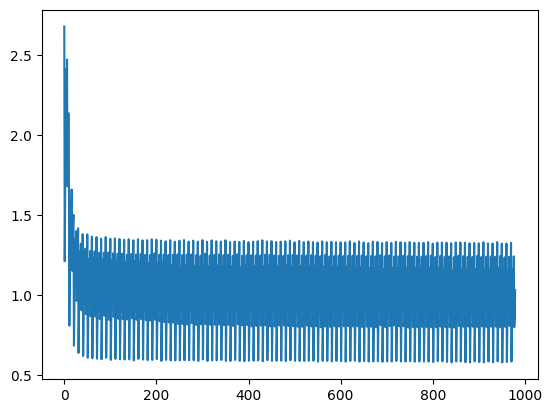

In [17]:
plt.plot(vl_losses_all)

In [18]:
np.mean(vl_losses_all[-500:])

0.979497195482254